In [1]:
import numpy as np
from os.path import join
import torch
import matplotlib.pyplot as plt
from density_estimator import DensityEstimator

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [29]:
np.random.seed(2)
choice = np.random.choice(10, 3, replace=False)
print(choice)

[4 1 5]


In [2]:
#plt.style.use('dark_background')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# data loading
data_path = "./input_data/"
outerdata_train = np.load(join(data_path, "outerdata_train.npy"))
innerdata_test = np.load(join(data_path, "innerdata_test.npy"))

In [4]:
# some data preprocessing functions
def logit_transform(x, min_vals, max_vals):
    with np.errstate(divide='ignore', invalid='ignore'):
        x_norm = (x - min_vals) / (max_vals - min_vals)
        logit = np.log(x_norm / (1 - x_norm))
    domain_mask = ~(np.isnan(logit).any(axis=1) | np.isinf(logit).any(axis=1))
    return logit, domain_mask

def standardize(x, mean, std):
    return (x - mean) / std

def inverse_logit_transform(x, min_vals, max_vals):
    x_norm = 1 / (1 + np.exp(-x))
    return x_norm * (max_vals - min_vals) + min_vals

def inverse_standardize(x, mean, std):
    return x * std + mean

In [5]:
# data preprocessing
preprocessing_params = {}
preprocessing_params["min"] = np.min(outerdata_train[:, 1:-1], axis=0)
preprocessing_params["max"] = np.max(outerdata_train[:, 1:-1], axis=0)

preprocessed_outerdata_train_x, mask = logit_transform(outerdata_train[:, 1:-1], preprocessing_params["min"], preprocessing_params["max"])
preprocessed_outerdata_train = np.hstack([outerdata_train[:, 0:1], preprocessed_outerdata_train_x, outerdata_train[:, -1:]])[mask]

preprocessing_params["mean"] = np.mean(preprocessed_outerdata_train[:, 1:-1], axis=0)
preprocessing_params["std"] = np.std(preprocessed_outerdata_train[:, 1:-1], axis=0)
preprocessed_outerdata_train[:, 1:-1] = standardize(preprocessed_outerdata_train[:, 1:-1], preprocessing_params["mean"], preprocessing_params["std"])

preprocessed_innerdata_test_x, mask = logit_transform(innerdata_test[:, 1:-1], preprocessing_params["min"], preprocessing_params["max"])
preprocessed_innerdata_test = np.hstack([innerdata_test[:, 0:1], preprocessed_innerdata_test_x, innerdata_test[:, -1:]])[mask]
preprocessed_innerdata_test[:, 1:-1] = standardize(preprocessed_innerdata_test[:, 1:-1], preprocessing_params["mean"], preprocessing_params["std"])

In [6]:
# loading flow model
flow_savedir = "./trained_flows/training_1/"
config_file = "./DE_MAF_model.yml"

val_losses = np.load(join(flow_savedir, "my_ANODE_model_val_losses.npy"))
best_epoch = np.argmin(val_losses)
model = DensityEstimator(config_file, eval_mode=True, load_path=join(flow_savedir, "my_ANODE_model_epoch_{}.par".format(best_epoch)), device=device)

DensityEstimator has 274800 parameters
Loading model parameters from ./trained_flows/training_1/my_ANODE_model_epoch_47.par


In [7]:
# drawing samples at the same conditional values as the inner data (sanity check)
m_vals = torch.from_numpy(preprocessed_innerdata_test[:, 0]).reshape((-1, 1)).type(torch.FloatTensor).to(device)
samples = model.model.sample(num_samples=len(m_vals), cond_inputs=m_vals)

phyiscal_samples = inverse_standardize(samples.cpu().detach().numpy(), preprocessing_params["mean"], preprocessing_params["std"])
phyiscal_samples = inverse_logit_transform(phyiscal_samples, preprocessing_params["min"], preprocessing_params["max"])

phyiscal_samples = np.hstack([preprocessed_innerdata_test[:, 0:1], phyiscal_samples, phyiscal_samples[:, -1:]])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


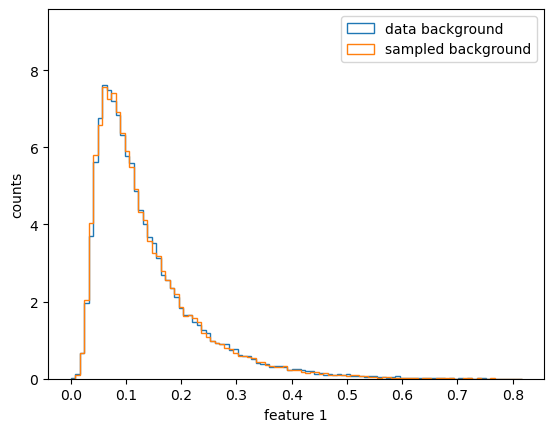

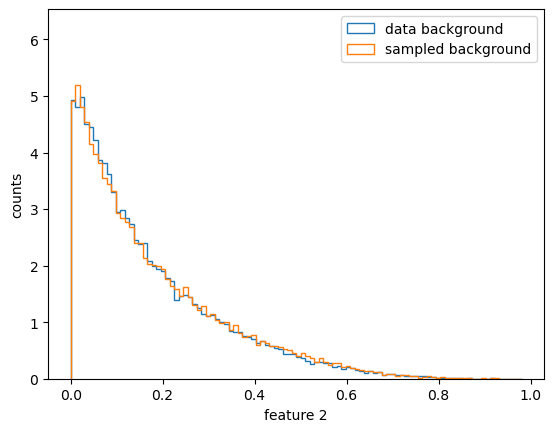

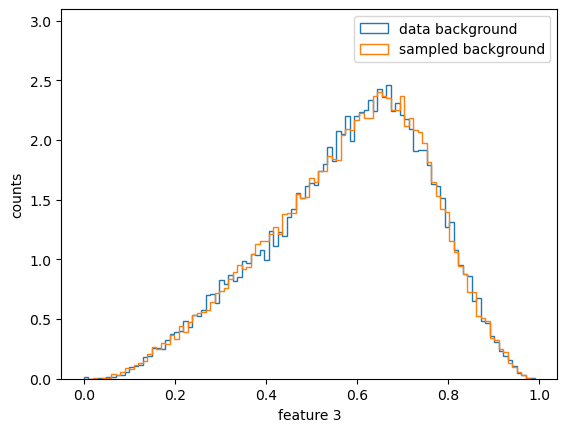

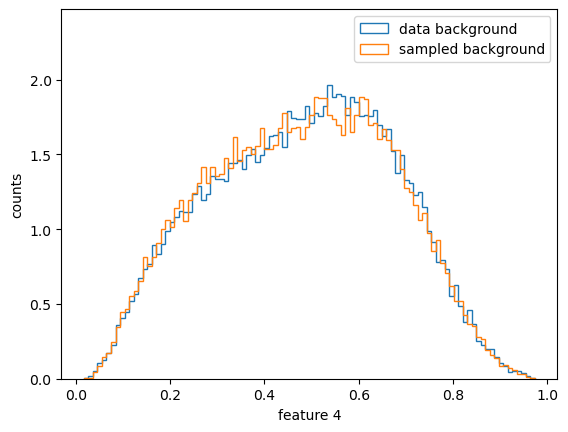

In [8]:
# comparing samples to inner background (sanity check)
for i in range(1, 5):
    _, binning, _ = plt.hist(innerdata_test[innerdata_test[:, -1] == 0, i], bins=100, label="data background", density=True, histtype="step")
    _ = plt.hist(phyiscal_samples[:, i], bins=binning, label="sampled background", density=True, histtype="step")
    plt.legend()
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.2)
    plt.xlabel("feature {}".format(i))
    plt.ylabel("counts")
    plt.show()


In [9]:
# evaluate likelihood of inner data points
logit_log_prob = model.model.log_probs(
    torch.from_numpy(preprocessed_innerdata_test[:, 1:-1]).float().to(device),
    torch.from_numpy(preprocessed_innerdata_test[:, 0].reshape(-1, 1)).float().to(device)
).detach().cpu().numpy().flatten()

# translating it to physical coordinates
log_prob = logit_log_prob + np.sum(
    np.log(
        2 * (1 + np.cosh(preprocessed_innerdata_test[:, 1:-1] * preprocessing_params["std"] + preprocessing_params["mean"]))
        / (preprocessing_params["std"] * (preprocessing_params["max"] - preprocessing_params["min"]))
    ), axis=1
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [10]:
print(log_prob)

[4.79903305 3.39289066 2.55856571 ... 3.755695   3.24197035 3.38412726]
